In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm

from tqdm.notebook import tqdm

from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN


import keras.utils as image
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input

In [2]:
DATASET = Path('f:/datasets/stars/')    # 9605 картинок

# Создадим список путей до файлов изображений
images = [pic.resolve() for pic in DATASET.glob("*") if pic.suffix in ('.png', '.jpg', '.jpeg')]

In [31]:
# Переведем список путей изображений в список данных для нейронной сети
for i in tqdm(range(len(images))):
    img = images[i]
    img = image.load_img(img, target_size=(256, 256))
    img = img.resize((224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    images[i] = img_data

print(images[0].shape)
# (1, 224, 224, 3)

  0%|          | 0/9605 [00:00<?, ?it/s]

(1, 224, 224, 3)


In [30]:
# Определим нейронную сеть для генерирования фич по данным изобоажения
model = EfficientNetB7(weights='imagenet', include_top=False)

258076736/258076736 [==============================] - 29s 0us/step


In [32]:
# Генерирование фич по данным изобоажения
net_feature_list = []
for img in tqdm(images):
    net_feature = model.predict(img, verbose=False)
    net_feature_np = np.array(net_feature)
    net_feature_list.append(net_feature_np.flatten())

net_feature_list = np.array(net_feature_list)

  0%|          | 0/9605 [00:00<?, ?it/s]

In [33]:
# Сохранение фич изображений, чтоб не ждать мин 40 в след раз
with open('star_v5_224_effnetb7.npy', 'wb') as output_file:
    np.save(output_file, net_feature_list)

In [34]:
# Считывание фич изображений, чтоб не ждать мин 40 в след раз
with open('star_v5_224_effnetb7.npy', 'rb') as input_file:
    net_feature_list = np.load(input_file)

In [35]:
# Нормализуем признаки
sc = StandardScaler()
net_feature_list_std = sc.fit_transform(net_feature_list)

In [36]:
# Сократим размерность
pca = PCA()
net_feature_list_pca = pca.fit_transform(net_feature_list_std)

In [37]:
print(net_feature_list_std[0].__len__())            # Базовая размерность 125440
print(net_feature_list_pca[0].__len__())            # Понизили размерность до 9605

125440
9605


In [38]:
# Сохранение фич изображений, чтоб не ждать мин 40 в след раз
with open('star_v6_224_effnetb7_pca.npy', 'wb') as output_file:
    np.save(output_file, net_feature_list_pca)

In [3]:
# Считывание фич изображений, чтоб не ждать мин 40 в след раз
with open('star_v6_224_effnetb7_pca.npy', 'rb') as input_file:
    net_feature_list_pca = np.load(input_file)

In [40]:
# Анализ на количество кластеров
def cluster_analysis_kmean(lst, start, stop, step):
    distortions = []

    for i in tqdm(range(start, stop+1, step)):
        model = KMeans(n_clusters=i,
                       init='random',   # k-means++ долго работает
                       n_init=2,
                       max_iter=300,
                       tol=1e-4,
                       random_state=0)
        model.fit(lst)
        distortions.append(model.inertia_)

    plt.figure(figsize=(15, 8))
    plt.plot(range(start, stop+1, step), distortions, marker="o")
    plt.xlabel("Кол-во кластеров")
    plt.xticks(range(start, stop+1, step))
    plt.ylabel("Искажений")
    plt.grid()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

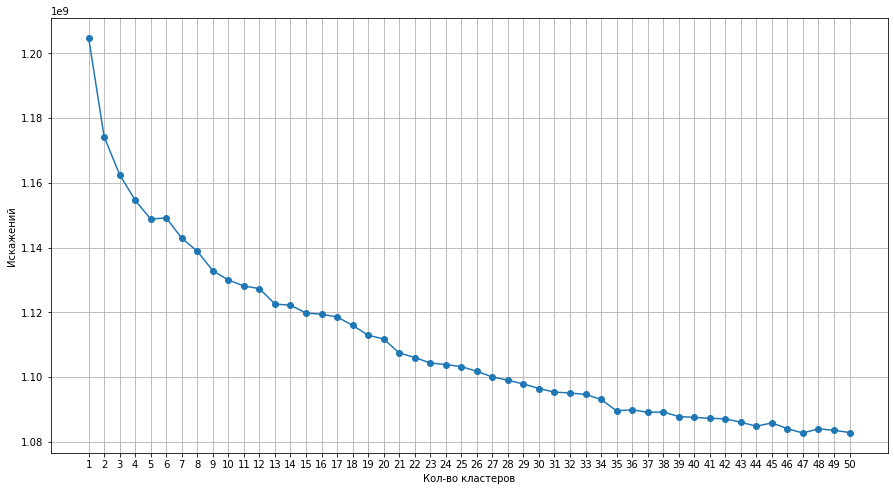

In [41]:
# Исследуем методом локтя оптимальное кол-во кластеров
cluster_analysis_kmean(net_feature_list_pca, 1, 50, 1)

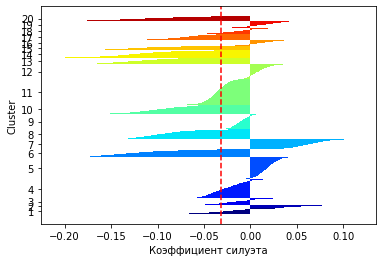

In [4]:
CLUSTERS = 20

model = KMeans(n_clusters=CLUSTERS,
               init='k-means++',
               n_init=5,
               max_iter=500,
               tol=1e-4,
               random_state=0,
               algorithm='lloyd')

preds = model.fit_predict(net_feature_list_pca)


cluster_labels = np.unique(preds)
silhouette_vals = silhouette_samples(net_feature_list_pca, preds, metric="euclidean")

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[preds==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / CLUSTERS)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor="none",
             color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Коэффициент силуэта")
plt.show()

In [5]:

# Создадим список путей до файлов изображений
images = [pic.resolve() for pic in DATASET.glob("*") if pic.suffix in ('.png', '.jpg', '.jpeg')]
df = pd.concat((pd.DataFrame(images), pd.DataFrame(preds)), axis=1)
df.iloc[:, 1].value_counts()

10    1245
4     1079
3      931
8      761
11     725
6      494
7      478
9      438
5      371
18     361
13     345
12     323
2      303
16     302
15     283
0      273
17     268
14     224
19     223
1      178
Name: 0, dtype: int64

In [9]:
df[df.iloc[:, 1] == 4].head(20)

,0,0
6,F:\datasets\stars\0006.png,4
10,F:\datasets\stars\0010.png,4
34,F:\datasets\stars\0034.png,4
45,F:\datasets\stars\0045.png,4
49,F:\datasets\stars\0049.png,4
52,F:\datasets\stars\0052.png,4
59,F:\datasets\stars\0059.png,4
64,F:\datasets\stars\0064.png,4
68,F:\datasets\stars\0068.png,4
75,F:\datasets\stars\0075.png,4
